In [1]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px
import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
params = {
    "cell_type_key": "cellType",
    "fig_fmt": "png",

    "selected_ct": ["0", "1", "2"],
    "bulk_file": "../../data/synthetic10/bulk.csv",
    "ref_annot_file": "../../data/GSE136148/pdata.tsv",
    "ref_file": "../../data/GSE136148/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}
true_df = pd.read_csv("../../data/synthetic10/bulk_proportions.csv", index_col=0)
true_df.drop(columns="n_cells", inplace=True)

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [3]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [4]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=0)
pheno_df.index.name = None

Reading pheno data...


In [5]:
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

3022

In [6]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
3      29
dtype: int64

In [7]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep=",", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 18880, genes: 10


In [8]:
if params["selected_ct"] is not None and len(params["selected_ct"]) > 0:
    sadata = sadata[sadata.obs[params["cell_type_key"]].astype("str").isin(params["selected_ct"]), :].copy()

sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
dtype: int64

In [9]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)

scRNA-seq data - cells: 2993, genes: 18880
bulk RNA-seq data - samples: 10, genes: 18880


In [10]:
decon = dv.DeconV(adata, cell_type_key="cellType", sub_type_key=None, layer="counts")

In [ ]:
decon.filter_outliers(dropout_factor_quantile=0.9, pseudobulk_lims=(-10,10), aggregate="max")

In [12]:
decon.init_dataset(
    weight_type=None, weight_agg="max",
    inverse_weight=False, log_weight=False, quantiles=(0, 1) #0,1
)
# dv.pl.gene_weight_hist(
#     decon.adata.varm["gene_weights"],
#     f"Gene Weight (abs_score | min)",
#     logy=False,
# )

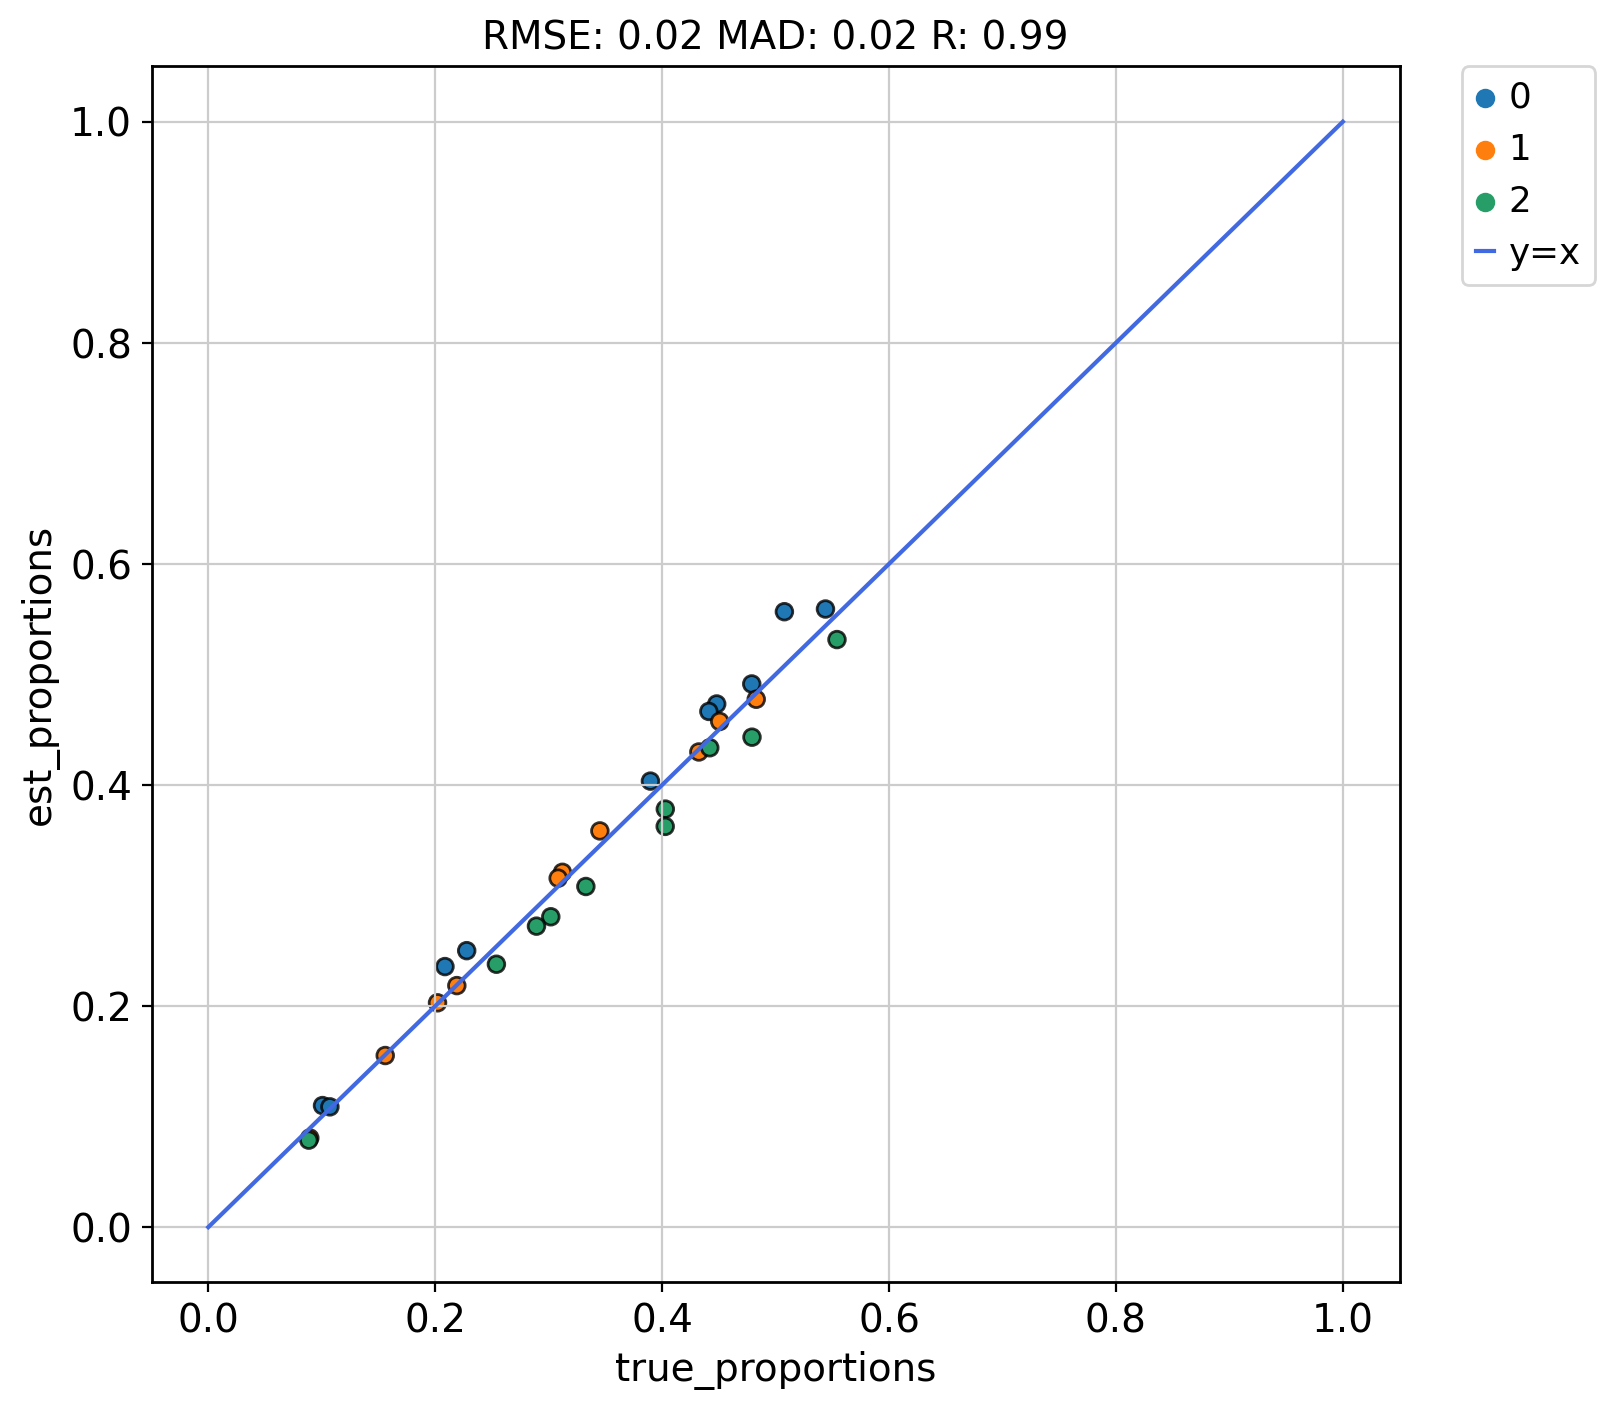

In [13]:
res = decon.deconvolute(
    model_type="poisson",
    num_epochs=1000,
    lr=0.1,
    use_outlier_genes=False,
    progress_bar=False,
    signature_quantiles=(0, 1.0), # 0,0.9
)
df_res = pd.DataFrame(res, columns=decon.cell_types, index=adata.uns["bulk_samples"]).reset_index(drop=True)
dv.pl.scatter_check(true_df, df_res, style=None)

In [20]:
def calculate_weights(adata, var):
    gene_weights = np.empty((adata.n_vars, decon.n_labels))

    for i, cell_type in enumerate(decon.labels):
        gene_weights[:, i] = adata.uns["de"]["cellType"][f"{cell_type} vs. rest"][var].values

    return gene_weights

In [21]:
est_bulk = np.log1p(np.sum(adata.varm["mu_expression_cellType"] * lrm.get_counts().detach().numpy(), axis=1))
true_bulk = np.log1p(adata.varm["bulk"][:, 0])

x = adata.varm["pseudo_factor"][:, 0]
y = true_bulk - est_bulk

_min = np.min([x.min(), y.min()])
_max = np.max([x.max(), y.max()])

f = px.scatter(
    x=adata.varm["pseudo_factor"][:, 0],
    y=true_bulk - est_bulk,
    color=calculate_weights(adata, "pvals_adj").min(1)
)
f.add_trace(
    go.Scatter(x=[_min, _max], y=[_min, _max], mode="lines", line=dict(dash="dash"))
)